### Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision import datasets

import numpy as np
import random
import matplotlib.pyplot as plt

### Download MNIST train and test set

In [4]:
mnist_train = datasets.MNIST(root='./data', download=False, train=True, transform=T.ToTensor())
mnist_test = datasets.MNIST(root='./data', download=False, train=False, transform=T.ToTensor())

In [5]:
len(mnist_train), len(mnist_test)

(60000, 10000)

### Seed everything for reproducibility

In [6]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(43)

### Custom Dataset

In [7]:
class MNISTRandDataset(Dataset):
    def __init__(self, mnist):
        self.mnist = mnist

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        image, label = self.mnist[idx]

        rand_num = random.randint(0, 9)

        rand_num_tensor = F.one_hot(torch.tensor(rand_num), num_classes=10)
        sum_label = label + rand_num
        self.sum_label = sum_label
        return image, rand_num_tensor, label, self.sum_label

### Train and Test Datasets

In [8]:
train_ds = MNISTRandDataset(mnist_train)
test_ds = MNISTRandDataset(mnist_test)

In [23]:
len(train_ds)

60000

In [7]:
train_ds[0][0].shape

torch.Size([1, 28, 28])

### Train and Test Loaders

In [8]:
train_loader = DataLoader(train_ds, 64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, 64, shuffle=False, num_workers=2, pin_memory=True)

### Model

In [9]:
class MNISTRandSumModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, 3)
        self.conv6 = nn.Conv2d(256, 512, 3)

        self.fc1 = nn.Linear(3*3*512, 1024)
        self.fc2 = nn.Linear(1024, 10)

        self.fc3 = nn.Linear(20, 19)

    def forward(self, image, rand_num):
        # (1) hidden conv1 layer
        image = self.conv1(image)
        image = F.relu(image)

        # (2) hidden conv2 layer
        image = self.conv2(image)
        image = F.relu(image)
        image = F.max_pool2d(image, kernel_size=2, stride=2)

        # (3) hidden conv3 layer
        image = self.conv3(image)
        image = F.relu(image)

        # (4) hidden conv4 layer
        image = self.conv4(image)
        image = F.relu(image)
        image = F.max_pool2d(image, kernel_size=2, stride=2)

        # (5) hidden conv5 layer
        image = self.conv5(image)
        image = F.relu(image)

        # (6) hidden conv6 layer
        image = self.conv6(image)
        image = F.relu(image)

        # (7) hidden linear layer
        image = torch.flatten(image, 1)
        image = self.fc1(image)
        image = F.relu(image)

        # (8) hidden linear layer
        image = self.fc2(image)
        out = image.clone()

        # (9) output layer
        sum_out = torch.cat((out, rand_num), dim=1)
        sum_out = self.fc3(sum_out)

        return out, sum_out

### Get the default device

In [10]:
def get_default_device():
    """
    Pick GPU if available, else CPU.
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

### Create a model and move it to GPU

In [11]:
model = MNISTRandSumModel()
model.to(device)

MNISTRandSumModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4608, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (fc3): Linear(in_features=20, out_features=19, bias=True)
)

### Accuracy metric

In [12]:
def accuracy(outputs, labels):
    """
    Calculates the accuracy.
    """
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Training and Testing

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = []

for epoch in range(25):
    result = {}

    train_losses = []
    test_losses = []
    train_accuracies_mnist = []
    train_accuracies_rand = []
    test_accuracies_mnist = []
    test_accuracies_rand = []

    # Training
    for images, rand_nums, labels, sums in train_loader:
        images, rand_nums, labels, sums = images.to(device), rand_nums.to(device), labels.to(device), sums.to(device)
        output_mnist, output_sum = model(images, rand_nums)

        loss_mnist = F.cross_entropy(output_mnist, labels)
        loss_rand = F.cross_entropy(output_sum, sums)

        loss = loss_mnist + loss_rand
        train_losses.append(loss)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_accuracies_mnist.append(accuracy(output_mnist, labels))
        train_accuracies_rand.append(accuracy(output_sum, sums))

    # Testing
    with torch.no_grad():
        for images, rand_nums, labels, sums in test_loader:
            images, rand_nums, labels, sums = images.to(device), rand_nums.to(device), labels.to(device), sums.to(device)

            output_mnist, output_sum = model(images, rand_nums)

            test_loss = F.cross_entropy(output_mnist, labels) + F.cross_entropy(output_sum, sums)
            test_losses.append(test_loss)

            test_accuracies_mnist.append(accuracy(output_mnist, labels))
            test_accuracies_rand.append(accuracy(output_sum, sums))

    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['test_loss'] = torch.stack(test_losses).mean().item()

    train_accuracy_mnist = torch.stack(train_accuracies_mnist).mean().item()
    train_accuracy_rand = torch.stack(train_accuracies_rand).mean().item()

    result['train_accuracy'] = (train_accuracy_mnist + train_accuracy_rand) / 2

    test_accuracy_mnist = torch.stack(test_accuracies_mnist).mean().item()
    test_accuracy_rand = torch.stack(test_accuracies_rand).mean().item()

    result['test_accuracy'] = (test_accuracy_mnist + test_accuracy_rand) / 2

    history.append(result)

    print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, test_loss: {result['test_loss']:.4f}, train_accuracy: {result['train_accuracy']:.4f}, test_accuracy: {result['test_accuracy']:.4f}")

Epoch [0], train_loss: 2.5492, test_loss: 2.1538, train_accuracy: 0.5539, test_accuracy: 0.6157
Epoch [1], train_loss: 2.0288, test_loss: 1.9166, train_accuracy: 0.6379, test_accuracy: 0.6677
Epoch [2], train_loss: 1.8538, test_loss: 1.7890, train_accuracy: 0.6590, test_accuracy: 0.6556
Epoch [3], train_loss: 1.7354, test_loss: 1.6887, train_accuracy: 0.6698, test_accuracy: 0.6729
Epoch [4], train_loss: 1.6427, test_loss: 1.6336, train_accuracy: 0.6838, test_accuracy: 0.6787
Epoch [5], train_loss: 1.5697, test_loss: 1.5666, train_accuracy: 0.6903, test_accuracy: 0.6873
Epoch [6], train_loss: 1.5064, test_loss: 1.5122, train_accuracy: 0.7048, test_accuracy: 0.7041
Epoch [7], train_loss: 1.4579, test_loss: 1.4675, train_accuracy: 0.7137, test_accuracy: 0.7034
Epoch [8], train_loss: 1.4077, test_loss: 1.4417, train_accuracy: 0.7243, test_accuracy: 0.7197
Epoch [9], train_loss: 1.3722, test_loss: 1.3894, train_accuracy: 0.7322, test_accuracy: 0.7418
Epoch [10], train_loss: 1.3267, test_los

### Plot Accuracies and Losses

In [14]:
def plot_accuracies(history):
    train_accuracies = [x['train_accuracy'] for x in history]
    test_accuracies = [x['test_accuracy'] for x in history]
    plt.figure(figsize=(12, 8))
    plt.plot(train_accuracies, '-x')
    plt.plot(test_accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train_accuracy', 'test_accuracy'])
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig('Accuracy.png');

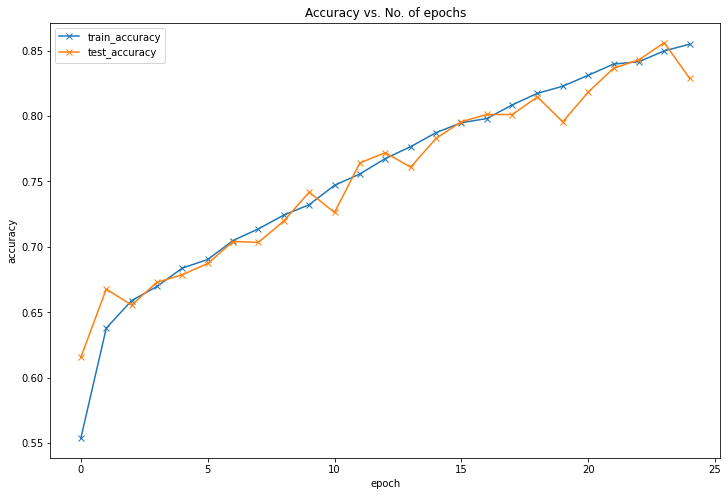

In [15]:
plot_accuracies(history)

In [16]:
def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    test_losses = [x['test_loss'] for x in history]
    plt.figure(figsize=(12, 8))
    plt.plot(train_losses, '-x')
    plt.plot(test_losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train_loss', 'test_loss'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig('Loss.png');

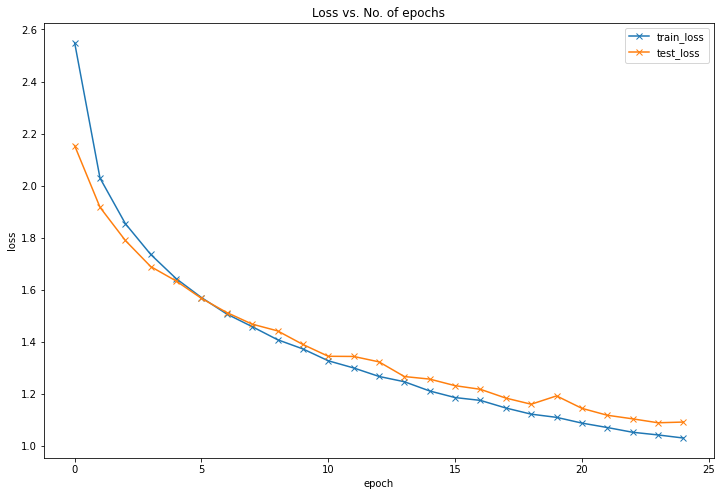

In [17]:
plot_losses(history)